Author: Lucas Camponogara Viera.

# Rule-of-thumbs

1. `Ockham's razor:` when there are two competing theories that make exactly the same predictions, the simpler one is better. In model complexity, the more complex the model, the more prone the model is to overfitting as the size of the dataset decreases. Therefore, one should always start with a baseline model.
2. `Learning principle:` random features (noise) cannot be learned. In a data-driven approach, the dataset must share a pattern of meaningful representation.
3. `Hold-out set:` it is a good practice to split the dataset into training, test, and validation.
4. `Dataset size:` the larger the dataset, the higher the generalization of the model to unseen data.
5. `Samples per parameter in Neural Networks:` ideally, there should be 10x the number of samples (feature-label pairs) than parameters (weights) in a neural network, i.e, ten examples per weight.
6. `Network depth:` the deeper the network (number of layers), the more information is extracted (learned).
7. `Bias-variance trade-off:` while under-parametrization can cause bias (underfitting), over-parametrization can cause variance (overfitting). In mainstream machine learning, one tries to find a balance.
8. `Double descent:` over-parametrization beyond certain interpolation threshold can lead to model generalization (good test performance). Moreover, as the size of the parameter vector to be optimized increases (as large as one million), the local minima get closer to the global minimum.
9. `Batch size:` a larger batch size (increase memory resource) leads to a speed up in training and to a lower asymptotic test accuracy (classification), and hence a lower generalization to unseen data.
10. `Learning rate:` a higher learning rate can speed-up training, however, too large a learning rate can make the loss function value to jiggle around the loss landscape and to never converge.

# Dependencies

In [2]:
#import numpy as np

import os
import torch
from PIL import Image
import torch.nn.functional as F
from torch import nn, save, load
from torchsummary import summary
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt

In [3]:
torch.__version__

'2.2.0'

In [4]:
import sys
sys.version

'3.10.0 (default, Mar  3 2022, 09:58:08) [GCC 7.5.0]'

# Dummy dataset

In [4]:
# Fake MNIST dataset
num_classes = 10
num_samples = 100
height = 28
width = height
num_channels = 1 # Grayscale.
train_shape = (num_samples, num_channels, height, width)
label_shape = (num_samples, num_classes)

# Normalizing dataset
mean = 0.0
stddev = 1.0

# NumPy:
#dummy_x = np.random.normal(mean, stddev, size=train_shape)
#dummy_y = np.random.normal(mean, stddev, size=label_shape)

# Torch:
dummy_x = torch.randn(train_shape) * stddev + mean
dummy_y = torch.randn(label_shape) * stddev + mean

#print(dummy_x.mean(), dummy_x.std()) # For NumPy only.
dummy_x.shape, dummy_y.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100, 10]))

In [5]:
# Hold-out set

x_train = dummy_x[:50] # First 50.
y_train = dummy_y[:50]
x_val = dummy_x[50:] # Remaining ones.
y_val = dummy_y[50:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([50, 1, 28, 28]),
 torch.Size([50, 10]),
 torch.Size([50, 1, 28, 28]),
 torch.Size([50, 10]))

# OOP (Sequential API)

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1, stride=1, bias=True),
            nn.BatchNorm2d(32, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1, bias=True),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        self.classifier = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(64*14*14, 50),
            nn.ReLU(),
            nn.Linear(50, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Forward pass method.'''
        x = self.conv_block(x)
        # Flattening:
        #print(x.size()) # torch.Size([100, 32, 7, 7])
        x = x.view(-1, 64*14*14) 
        x = self.classifier(x)
        return x

In [7]:
sample_input = torch.ones((10, 1, 28, 28))

model = NeuralNetwork(num_classes).to('cpu')
model(sample_input).shape                        

torch.Size([10, 10])

In [8]:
# input_shape is (channel, height, width)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
              ReLU-6           [-1, 64, 14, 14]               0
            Linear-7                   [-1, 50]         627,250
              ReLU-8                   [-1, 50]               0
            Linear-9                   [-1, 10]             510
          Softmax-10                   [-1, 10]               0
Total params: 646,640
Trainable params: 646,640
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.81
Params size (MB): 2.47
Estimated T

# OOP (Functional API)

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1, stride=1, bias=True)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1, bias=True)
        self.fc1 = nn.Linear(64 * 14 * 14, 50)  
        self.fc2 = nn.Linear(50, num_classes)
        self.bn = nn.BatchNorm2d(32, affine=True)
        #self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        '''Forward pass method.'''
        x = self.conv1(x)
        x = F.relu(self.bn(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        #x = self.pool(x)
        #print(x.size()) # torch.Size([100, 32, 14, 14])
        # Flattening:
        x = x.view(-1, 64 * 14 * 14)
        #x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [10]:
sample_input = torch.ones((100, 1, 28, 28))

model = NeuralNetwork(num_classes).to('cpu')
model(sample_input).shape                        

torch.Size([100, 10])

In [11]:
# input_shape is (channel, height, width)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
            Linear-5                   [-1, 50]         627,250
            Linear-6                   [-1, 10]             510
Total params: 646,640
Trainable params: 646,640
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.53
Params size (MB): 2.47
Estimated Total Size (MB): 3.00
----------------------------------------------------------------


# Train

Dummy dataset.

In [12]:
# Device ('cuda' or 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
learning_rate = 1e-4
epochs = 10
batch_size = 10
num_passes = len(x_train)/batch_size

# Model
model = NeuralNetwork(num_classes=10).to(device)

# Loss
loss = nn.CrossEntropyLoss()

# Optimizers
opt1 = Adam(model.parameters(), learning_rate)
opt2 = SGD(model.parameters(), learning_rate, momentum=0.9)

In [13]:
for epoch in range(epochs):
    train_loss_value = 0.0
    val_loss_value = 0.0

    # Training phase
    model.train()  # Set the model to training mode
    for i in range(0, len(x_train), batch_size):
        # Iterating over the dataset in batches of n samples
        x_train_batch, y_train_batch = x_train[i:i+batch_size], y_train[i:i+batch_size]
        x_train_batch, y_train_batch = x_train_batch.to(device), y_train_batch.to(device)
        #print(x.shape, y.shape)

        # Forward pass (prediction)
        yhat_train = model(x_train_batch)

        # Compute loss
        train_loss = loss(yhat_train, y_train_batch)
        train_loss_value += torch.abs(train_loss).item()

        # Reset gradients
        opt1.zero_grad()
        # Backpropagate
        train_loss.backward()
        # Update weights
        opt1.step()
    
    # Validation phase
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        for i in range(0, len(x_val), batch_size):
            x_val_batch, y_val_batch = x_val[i:i+batch_size], y_val[i:i+batch_size]
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)

            # Forward pass (prediction)
            yhat_val = model(x_val_batch)

            # Compute loss
            val_loss_value += torch.abs(loss(yhat_val, y_val_batch)).item()

    # Average Training Loss
    train_loss_value /= num_passes
    # Average Validation Loss
    val_loss_value /= num_passes
        
    print(f'Epoch: {epoch+1} | Training Loss: {train_loss_value} | Validation Loss: {val_loss_value}')

Epoch: 1 | Training Loss: 2.521962022781372 | Validation Loss: 1.6545334696769713
Epoch: 2 | Training Loss: 2.5050134539604185 | Validation Loss: 1.6568998336791991
Epoch: 3 | Training Loss: 2.5259711861610414 | Validation Loss: 1.6604255557060241
Epoch: 4 | Training Loss: 2.549936854839325 | Validation Loss: 1.6684385180473327
Epoch: 5 | Training Loss: 2.540916085243225 | Validation Loss: 1.682846486568451
Epoch: 6 | Training Loss: 2.5175208687782287 | Validation Loss: 1.6868875861167907
Epoch: 7 | Training Loss: 2.5163288474082948 | Validation Loss: 1.6757380485534668
Epoch: 8 | Training Loss: 2.5130046248435973 | Validation Loss: 1.6704510688781737
Epoch: 9 | Training Loss: 2.498608422279358 | Validation Loss: 1.655423492193222
Epoch: 10 | Training Loss: 2.491582727432251 | Validation Loss: 1.6599570631980896


# Example: MNIST

## Data Preprocessing

In [18]:
batch_size = 10

# Load the MNIST dataset
mnist = datasets.MNIST(root='data', download=True, train=True, transform=ToTensor())

# Split the dataset into training and validation sets
total_size = len(mnist)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Use torch.utils.data.random_split for the splitting
train_dataset, val_dataset = torch.utils.data.random_split(mnist, [train_size, val_size])

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

## Training

In [7]:
# Device ('cuda' or 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
learning_rate = 1e-4
epochs = 20

# Model
model = NeuralNetwork(num_classes=10).to(device)

# Loss
loss = nn.CrossEntropyLoss()

# Optimizers
opt1 = Adam(model.parameters(), learning_rate)
opt2 = SGD(model.parameters(), learning_rate, momentum=0.9)

In [23]:
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(epochs):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    total_val_correct = 0
    total_val_samples = 0
    
    # Training phase
    model.train()  # Set the model to training mode
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Forward pass (prediction)
        yhat_train = model(x)

        # Compute loss
        train_loss = loss(yhat_train, y)
        epoch_train_loss += torch.abs(train_loss).item()

        # Reset gradients
        opt1.zero_grad()
        # Backpropagate
        train_loss.backward()
        # Update weights
        opt1.step()

        # Compute accuracy
        _, predicted = torch.max(yhat_train, 1)
        total_train_correct += (predicted == y).sum().item()
        total_train_samples += y.size(0)

    # Validation phase
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        for batch in val_loader:
            x_val_batch, y_val_batch = batch
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)

            # Forward pass (prediction)
            yhat_val = model(x_val_batch)

            # Compute loss
            epoch_val_loss += torch.abs(loss(yhat_val, y_val_batch)).item()
            
            # Compute accuracy
            _, predicted = torch.max(yhat_val, 1)
            total_val_correct += (predicted == y_val_batch).sum().item()
            total_val_samples += y_val_batch.size(0)

    # Average Training Loss
    epoch_train_loss /= (total_train_samples/batch_size)
    # Average Training Accuracy
    epoch_train_accuracy = total_train_correct / total_train_samples
    # Average Val Loss
    epoch_val_loss /= (total_val_samples/batch_size)
    # Average Val Accuracy
    epoch_val_accuracy = total_val_correct / total_val_samples
    # History
    history['loss'].append(epoch_train_loss)
    history['accuracy'].append(epoch_train_accuracy)
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_accuracy)
    
    print(f'Epoch: {epoch+1} | Train Loss: {epoch_train_loss:.4f} | Train Accuracy: {epoch_train_accuracy:.4f} \
    Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {epoch_val_accuracy:.4f}')

if not os.path.exists('./models/torch'):
    os.makedirs('./models/torch')
    
with open('./models/torch/mnist_cnn_model.pt', 'wb') as f:
    save(model.state_dict(), f)

Epoch: 1 | Train Loss: 1.5515 | Train Accuracy: 0.9202     Val Loss: 1.5018 | Val Accuracy: 0.9630
Epoch: 2 | Train Loss: 1.4933 | Train Accuracy: 0.9708     Val Loss: 1.4851 | Val Accuracy: 0.9782
Epoch: 3 | Train Loss: 1.4839 | Train Accuracy: 0.9793     Val Loss: 1.4802 | Val Accuracy: 0.9825
Epoch: 4 | Train Loss: 1.4783 | Train Accuracy: 0.9844     Val Loss: 1.4847 | Val Accuracy: 0.9784
Epoch: 5 | Train Loss: 1.4761 | Train Accuracy: 0.9862     Val Loss: 1.4787 | Val Accuracy: 0.9835
Epoch: 6 | Train Loss: 1.4740 | Train Accuracy: 0.9879     Val Loss: 1.4759 | Val Accuracy: 0.9858
Epoch: 7 | Train Loss: 1.4720 | Train Accuracy: 0.9900     Val Loss: 1.4763 | Val Accuracy: 0.9855
Epoch: 8 | Train Loss: 1.4709 | Train Accuracy: 0.9909     Val Loss: 1.4738 | Val Accuracy: 0.9879
Epoch: 9 | Train Loss: 1.4693 | Train Accuracy: 0.9925     Val Loss: 1.4734 | Val Accuracy: 0.9887
Epoch: 10 | Train Loss: 1.4680 | Train Accuracy: 0.9937     Val Loss: 1.4738 | Val Accuracy: 0.9878
Epoch: 11

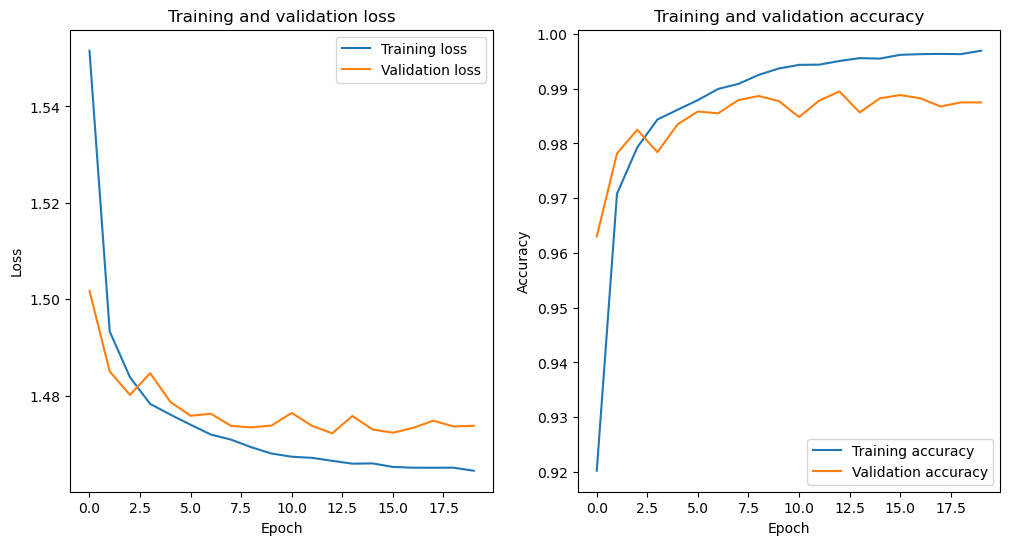

In [24]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the training and validation loss
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the training and validation accuracy
    ax2.plot(history['accuracy'], label='Training accuracy')
    ax2.plot(history['val_accuracy'], label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

plot_history(history)

## Predictions

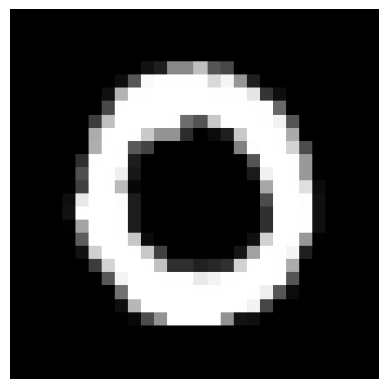

tensor(0)


In [9]:
# Open and convert the image to grayscale
img = Image.open('assets/test.png').convert('L')

# Display the image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# Convert image to Tensor
img = ToTensor()(img).unsqueeze(0)

# Resize the image to match the neural network input
img = F.interpolate(img, size=(28, 28), mode='bilinear', align_corners=False).to(device)

# Load the pre-trained model
with open('models/torch/mnist_cnn_model.pt', 'rb') as f:
    model.load_state_dict(load(f))

# make a prediction
print(torch.argmax(model(img)))

# References

[1] https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html